In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dense, Dropout, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/augusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [2]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
b2wCorpus['overall_rating'].replace({2: 1, 3: 1,4: 5}, inplace = True)
b2wCorpus['overall_rating'].replace({1: 0}, inplace = True)
b2wCorpus['overall_rating'].replace({5: 1}, inplace = True)
#d = b2wCorpus.index[b2wCorpus["overall_rating"] == 2].tolist()
#b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
#b2wCorpus['overall_rating'].replace({5: 2}, inplace = True)
#print(b2wCorpus.head)

In [3]:
SEQUENCE_MAXLEN = 40

# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [4]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [5]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    1  contente compra entrega rapida unico problema ...
1                    1        apenas consegui comprar lindo copo acrilico
2                    1  supera agilidade praticidade outras panelas el...
3                    1          filho amou parece verdade tantos detalhes
4                    1  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               1  vale usando controle xbox durou semana carga p...
132369               1  pratico barato super indico produto corre dia ...
132370               1    chegou antes prazo previsto corresponde anuncio
132371               0  material fraco poderia ser melhor ficou devend...
132372               0  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [6]:
b2wCorpus.overall_rating .value_counts().sort_index()

0    52073
1    80300
Name: overall_rating, dtype: int64

In [7]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    0  tudo certo pedido entrega recomendo compra int...
1                    0  comprei prancha garantia estendida desde chego...
2                    1  ja comprei varias coisas quero continuar compr...
3                    1             ainda nao instalei exatamente esperava
4                    1   chegou prazo atendeu expectativas melhorou sinal
...                ...                                                ...
132368               0                    mede mts mts medida vou comprar
132369               1             material entregue prazo recomendo site
132370               0  ainda nao recebi produto nao avalia lo ja ligu...
132371               1   acho moto otimo aparelho queria saber moto xt xt
132372               0  comprei testar pois pretendo adquirir unidades...

[132373 rows x 2 columns]>


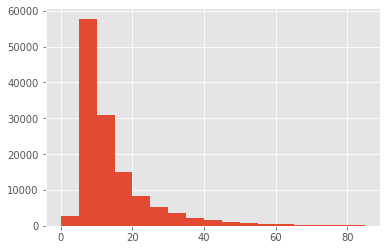

131993


In [8]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=100 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
plt.show()
print(len(Words))

In [9]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '199999'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [10]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [11]:
b2wCorpus.shape

(132373, 3)

In [12]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 10].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > SEQUENCE_MAXLEN].index)

In [13]:
#b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [14]:
b2wCorpus.shape

(65887, 3)

In [15]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [16]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,0,"[9735, 22657, 1918, 16199, 123, 428, 8867, 224...",23
1,1,"[12783, 9735, 20341, 457, 386, 947, 14705, 101...",11
2,1,"[902, 101071, 12783, 9735, 178, 18612, 176849,...",11
3,0,"[902, 930, 10185, 3223, 404, 2100, 104, 5460, ...",16
4,0,"[2989, 138, 39, 226, 1135, 7804, 428, 2369, 71...",29


In [17]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [18]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=SEQUENCE_MAXLEN, padding='post').tolist()

In [19]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,0,"[9735, 22657, 1918, 16199, 123, 428, 8867, 224...",23
1,1,"[12783, 9735, 20341, 457, 386, 947, 14705, 101...",11
2,1,"[902, 101071, 12783, 9735, 178, 18612, 176849,...",11
3,0,"[902, 930, 10185, 3223, 404, 2100, 104, 5460, ...",16
4,0,"[2989, 138, 39, 226, 1135, 7804, 428, 2369, 71...",29


In [20]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [21]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [22]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
34018,0,"[2989, 3435, 372, 7804, 22522, 3006, 7804, 116...",40
58916,1,"[517, 101071, 20017, 199999, 1150, 41021, 967,...",40
28915,0,"[902, 494, 39, 22097, 724, 404, 39, 199999, 17...",40
19217,0,"[305, 1129, 293, 111326, 5405, 9735, 106, 3183...",40
37535,0,"[20969, 3563, 8306, 11264, 930, 7804, 199999, ...",40


In [23]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
14801               0  [7804, 30218, 194, 3495, 92632, 9735, 902, 202...   40
46260               0  [7256, 6689, 193, 104, 166780, 9735, 2689, 543...   40
22293               0  [18874, 265, 7804, 7256, 12783, 1643, 199999, ...   40
16636               0  [902, 20798, 39, 199999, 3397, 532, 53, 635, 6...   40
50249               1  [226, 11759, 1771, 21469, 3223, 3650, 678, 542...   40
...               ...                                                ...  ...
12028               1  [428, 131, 566, 2104, 902, 981, 89314, 46237, ...   10
6829                1  [9735, 11072, 39884, 428, 70, 131, 7930, 6244,...   10
63251               1  [2789, 78567, 3223, 199999, 2104, 101071, 1530...   10
38016               1  [1278, 11735, 10547, 2499, 131, 566, 10547, 42...   10
48753               0  [902, 7126, 1771, 20405, 24509, 321, 1771, 321...   10

[6588 rows x 3 columns]>

In [24]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
65445               0  [363, 303, 7256, 10138, 9735, 188512, 930, 976...   40
7254                1  [4710, 51890, 153, 3006, 199999, 82034, 203, 2...   40
15596               0  [226, 86, 90008, 25099, 9735, 11264, 1345, 122...   40
20607               0  [1643, 600, 25999, 50697, 8653, 31182, 1101, 5...   40
23104               0  [902, 428, 8393, 293, 173, 99, 199999, 180, 11...   40
...               ...                                                ...  ...
9168                0  [3656, 36387, 18874, 114787, 7804, 464, 199999...   10
7368                1  [2532, 1968, 6376, 902, 290, 1142, 795, 943, 3...   10
13615               1  [985, 20341, 3012, 8517, 3830, 18453, 3006, 29...   10
16465               1  [8567, 233, 3798, 2499, 6851, 25236, 502, 616,...   10
37552               0  [234, 330, 98124, 218, 215, 9005, 147012, 330,...   10

[16473 rows x 3 columns]>

In [25]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [26]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()
#emb.trainable = True

In [27]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(keras.layers.LSTM(128, dropout=0.5))
#model.add(Dropout(0.50))
#model.add(keras.layers.Dense(5, activation='softmax'))
#opt = tf.keras.optimizers.SGD(learning_rate=.1, momentum=.5)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.01, beta_1=.9, beta_2=.9, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
#opt="adam"
#model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    x= x_train, y=y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val))


Epoch 1/50
2677/2677 [==============================] - 48s 18ms/step - loss: 0.5371 - accuracy: 0.7404 - val_loss: 0.4500 - val_accuracy: 0.7989
Epoch 2/50
2677/2677 [==============================] - 46s 17ms/step - loss: 0.4653 - accuracy: 0.7873 - val_loss: 0.4050 - val_accuracy: 0.8200
Epoch 3/50
2677/2677 [==============================] - 46s 17ms/step - loss: 0.4396 - accuracy: 0.8018 - val_loss: 0.3864 - val_accuracy: 0.8326
Epoch 4/50
2677/2677 [==============================] - 47s 18ms/step - loss: 0.4222 - accuracy: 0.8090 - val_loss: 0.3745 - val_accuracy: 0.8353
Epoch 5/50
2677/2677 [==============================] - 48s 18ms/step - loss: 0.4113 - accuracy: 0.8150 - val_loss: 0.3654 - val_accuracy: 0.8423
Epoch 6/50
2677/2677 [==============================] - 47s 18ms/step - loss: 0.3995 - accuracy: 0.8239 - val_loss: 0.3598 - val_accuracy: 0.8473
Epoch 7/50
2677/2677 [==============================] - 47s 18ms/step - loss: 0.3894 - accuracy: 0.8297 - val_loss: 0.3573 -

In [29]:
#print(opt)

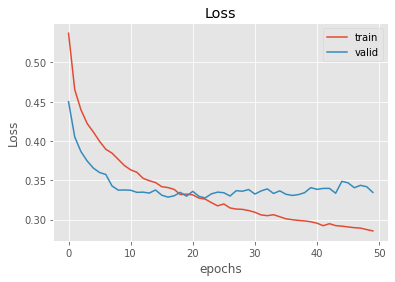

In [30]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

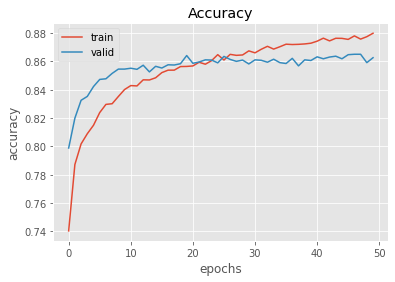

In [31]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();